# Preprocessing of dMRI data

This preprocessing is based on Wiktor's work with dMRI data. A specific file is taken as an example.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import nibabel as nib
from os import listdir
from os.path import isfile, join
from scipy import signal

In [5]:
# current path
cur_path = os.getcwd()
# file name and path
file = "BB_003_3T_cmrr_mbep2d_diff_0pt2_1_task_18s_off_12s_on_20200710180104_8"
file_name = cur_path + "/" + str(file) + "/dfMRI_raw.nii.gz"
# loading nifti object/header
raw_data_ = nib.load(file_name)
header  = raw_data_.header
raw_data = raw_data_.get_fdata()

In [6]:
header.get_xyzt_units(), raw_data.shape

('mm', 'sec')

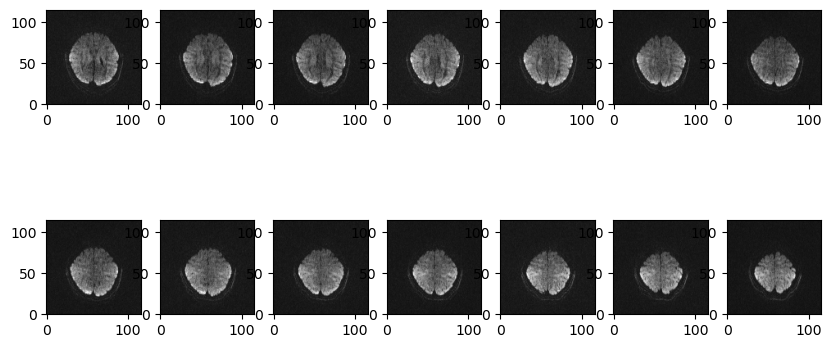

In [86]:
# print all slices wrt z axis after defining a random time 
slices = []
time = 15
for s in range(raw_data.shape[2]):
    z_slice = raw_data[:, :, s,time]
    slices.append(z_slice)
            
nrows = 2
ncols=int(len(slices)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 5))

for i, slice in enumerate(slices):
    ax[i//ncols][i%ncols].imshow(slice.T, cmap="gray", origin="lower")

# Getting rid of the first volumes

1st volume for some scans has to be removed as sometimes it has another b-value than the remaining volumes (we wanted to cover different b-values - calibration issues)


In [110]:
No_dummies_out = 2
dfMRI_raw  = raw_data[:,:,:,No_dummies_out:]
No_volumes = raw_data.shape[3] - No_dummies_out
dfMRI_raw.shape, No_volumes

((116, 116, 14, 598), 598)

# Identifying volume outliers and removing them

In [99]:
if "diff" in file_name:
    # if it is diffusion data
    make_adc = True
else :
    # BOLD 
    make_adc = False

In [100]:
# compress into 2D
dfMRI_raw_2D = dfMRI_raw.reshape(dfMRI_raw.shape[0]*dfMRI_raw.shape[1]*dfMRI_raw.shape[2], dfMRI_raw.shape[3])

In [101]:
dfMRI_raw_2D.shape

(188384, 598)

In [102]:
# mean over the volume
mean_dfMRI_raw_2D = np.mean(dfMRI_raw_2D, axis = 0)

In [103]:
mean_dfMRI_raw_2D.shape

(598,)

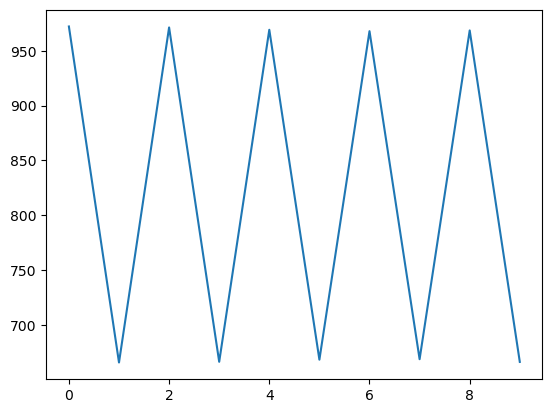

In [104]:
plt.plot(mean_dfMRI_raw_2D[:10])

This shows that there are 2 different b values in the data that need to be separated

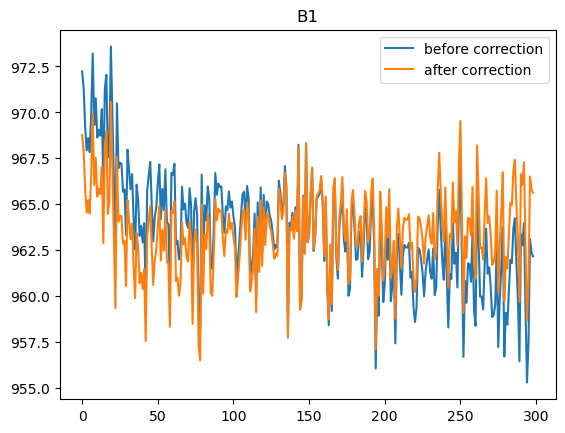

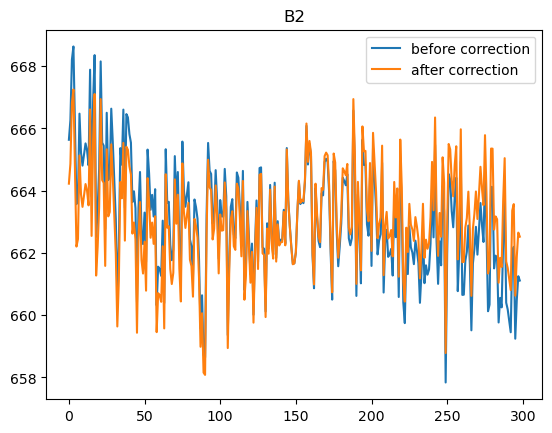

In [105]:
# acquisition scheme : b1-b2-b1-b2-b1-.... 
# => 2 series of b values
nb_series = 2
vol_outliers_thr = 0.01

if make_adc:

    for i in range(nb_series):
        # separate b values according to their index
        b_idx = np.arange(i, len(mean_dfMRI_raw_2D), 2)
        b_mean_dfMRI = mean_dfMRI_raw_2D[b_idx]
        length_b = len(b_mean_dfMRI)
        b_dfMRI_raw = dfMRI_raw[...,b_idx]
    
        # detrend for movement correction
        b_mean_dfMRI_det = signal.detrend(b_mean_dfMRI) - np.mean(signal.detrend(b_mean_dfMRI)) \
                           + np.mean(b_mean_dfMRI)

        plt.figure()
        plt.plot(b_mean_dfMRI, label = "before correction")
        plt.plot(b_mean_dfMRI_det, label = "after correction")
        plt.title(f"B{i+1}")
        plt.legend()

        # Find outliers (if any)
        b_mean_dfMRI_outliers = b_mean_dfMRI_det.copy()
        med = np.median(b_mean_dfMRI_outliers)
        b_idx_outliers = np.where(abs(b_mean_dfMRI_outliers- med) > vol_outliers_thr*med)

        # Remove the outliers (if any)
        if b_idx_outliers:
            b_mean_dfMRI_det[b_idx_outliers] = np.nan
            b_idx_non_outliers = np.setdiff1d(np.linspace(0, length_b-1, length_b), b_idx_outliers).astype(int)

        # Interpolation doesn't work for 1st and last elements - they cannot be Nan
        b_mean_dfMRI_det[0] = b_mean_dfMRI_det[b_idx_non_outliers[0]]
        b_mean_dfMRI_det[-1] = b_mean_dfMRI_det[b_idx_non_outliers[-1]]
        b_dfMRI_raw[...,0] = b_dfMRI_raw[..., b_idx_non_outliers[0]]
        b_dfMRI_raw[...,-1] = b_dfMRI_raw[..., b_idx_non_outliers[-1]]

        # If the first non-outliers idx is not 0, then add 0
        # Indeed, volume 0 cannot be interpolated with surrounding volumes
        if b_idx_non_outliers[0] > 0 : b_idx_non_outliers = [0, b_idx_non_outliers]
        # Same logic but for last volume
        if b_idx_non_outliers[-1] < length_b : b_idx_non_outliers = [b_idx_non_outliers, length_b-1]

        # If the mean of a volume is 0, then find the first non outliers id before and after 
        # the current volume_id and replace it by the avg of id_before and id_after
        for volume_idx in range(1, length_b):
            if b_mean_dfMRI_det[volume_idx] == 0:
                # Idx before volume_idx that contains a non-outliers
                idx_before = max(b_idx_non_outliers[b_idx_non_outliers < volume_idx])
                # Idx after volume_idx that contains a non-outliers
                idx_after = max(b_idx_non_outliers[b_idx_non_outliers > volume_idx])
                b_mean_dfMRI_det[volume_idx] = (b_mean_dfMRI_det[idx_before]+b_mean_dfMRI_det[idx_after])/2
                b_dfMRI_raw[...,volume_idx] = (b_dfMRI_raw[...,idx_before]+b_dfMRI_raw[...,idx_after])/2

        # Put the corrected value in the raw volume (with all b)
        mean_dfMRI_raw_2D[b_idx] = b_mean_dfMRI_det
        dfMRI_raw[...,b_idx] = b_dfMRI_raw

        

In [106]:
del b_mean_dfMRI_outliers, b_idx_non_outliers, b_idx_outliers, mean_dfMRI_raw_2D

In [107]:
img = nib.Nifti1Image(dfMRI_raw, np.eye(4))

In [108]:
dfMRI_raw.shape

(116, 116, 14, 598)

In [109]:
nib.save(img, 'test_part1.nii.gz')  

# PCA denoising

Open terminal in the right folder and run :

dwidenoise test_part1.nii.gz test_part2.nii.gz -noise noise.nii.gz -extent 9 -force

In [28]:
file_name = cur_path + "/test_part2.nii.gz"
# loading nifti object
pca_dfmri = nib.load(file_name)
pca_dfmri = pca_dfmri.get_fdata()

EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
file_name = cur_path + "/noise.nii.gz"
# loading nifti object
noise = nib.load(file_name)
noise = noise.get_fdata()

In [ ]:
# print all slices wrt z axis after defining a random time 
slices = []
time = 15
for s in range(pca_dfmri.shape[2]):
    z_slice = pca_dfmri[:, :, s,time]
    slices.append(z_slice)
            
nrows = 2
ncols=int(len(slices)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
ii = 0
for i, slice in enumerate(slices):
    row = int(ii/ncols)
    col = ii%ncols
    ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
    ii = ii + 1

In [30]:
noise.shape

(116, 116, 14)

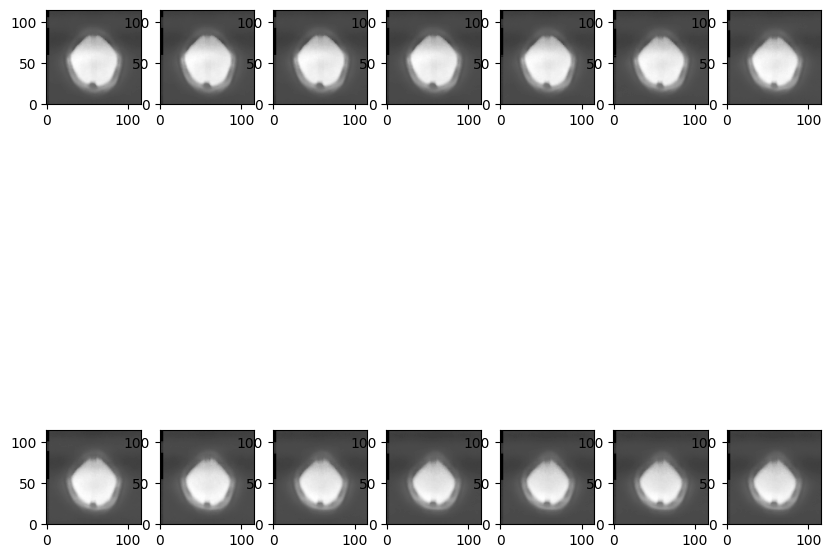

In [31]:
# print all slices wrt z axis after defining a random time 
         
nrows = 2
ncols=int(len(slices)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
ii = 0
for i in range(noise.shape[2]):
    slice = noise[:,:,i]
    row = int(ii/ncols)
    col = ii%ncols
    ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
    ii = ii + 1